In [0]:
#@title 神经网络 { display-mode: "both" }
# 程序实现包含多个隐藏层的神经网络,激活函数为sigmoid函数
# 本程序中实现的是包含2个隐层的神经网络，具体结果见 NN.ipynb
# 网络的能力与包含单个隐层的小波神经网络相当
# 详见 Wavelet_NN.py 和 Wavelet_NN.ipynb
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from numpy.linalg import norm
import numpy as np 
import time

In [0]:
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        func(*args, **kwargs)
        end_time = time.time()
        print('Training time is :{:.2f} s.'.format(end_time - start_time))
    return wrapper

## 定义网络结构类

In [0]:
class NeuralNet(object):  
    # 初始化神经网络，sizes是神经网络的层数和每层神经元个数
    def __init__(self, sizes):
        self.sizes_ = sizes
        self.num_layers_ = len(sizes)  # 层数
        self.w_ = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]  # w_、b_初始化为正态分布随机数
        self.b_ = [np.random.randn(y, 1) for y in sizes[1:]]
    
    # 标签转化
    def one_hot(self, x, num_classes):
        x = x.flatten().astype('uint8')
        m = x.shape[0]
        x_onehot = np.zeros((m, num_classes))
        for i in range(m):
            x_onehot[i, x[i]] = 1
        return x_onehot

    # Sigmoid函数，S型曲线
    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    # Sigmoid函数的导函数
    def sigmoid_der(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def feedforward(self, x):
        n = self.w_[0].shape[1]
        x = x.reshape(n, -1)
        for b, w in zip(self.b_, self.w_):
            x = self.sigmoid(np.dot(w, x) + b)
        return x
    
    # 反向传播算法
    def backprop(self, x, y):
        b_new = [np.zeros(b.shape) for b in self.b_]
        w_new = [np.zeros(w.shape) for w in self.w_]
    
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.b_, self.w_):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)
    
        delta = self.cost_derivative(activations[-1], y) * self.sigmoid_der(zs[-1])
        b_new[-1] = delta
        w_new[-1] = np.dot(delta, activations[-2].transpose())
    
        for l in range(2, self.num_layers_):
            z = zs[-l]
            sp = self.sigmoid_der(z)
            delta = np.dot(self.w_[-l+1].transpose(), delta) * sp
            b_new[-l] = delta
            w_new[-l] = np.dot(delta, activations[-l-1].transpose())
        return (b_new, w_new)
    
    # 更新权值w，偏移b
    def update_mini_batch(self, mini_batch, lr):
        b_new = [np.zeros(b.shape) for b in self.b_]
        w_new = [np.zeros(w.shape) for w in self.w_]
        a, b = mini_batch[:,:-1], self.one_hot(mini_batch[:, -1], num_classes=10)
        n = np.float(mini_batch.shape[0])
        for i in range(int(n)):
            x, y = a[i, :].reshape(-1, 1), b[i, :].reshape(-1, 1)
            delta_b_new, delta_w_new = self.backprop(x, y)
            b_new = [nb + dnb for nb, dnb in zip(b_new, delta_b_new)]
            w_new = [nw + dnw for nw, dnw in zip(w_new, delta_w_new)]
        self.w_ = [w - lr * nw for w, nw in zip(self.w_, w_new)]
        self.b_ = [b - lr * nb for b, nb in zip(self.b_, b_new)]
    
    # training_data是训练数据(x, y), epochs是训练次数, mini_batch_size是每次训练样本数, lr是learning rate，step是展示的迭代间隔
    @timer
    def SGD(self, training_data, epochs=100, mini_batch_size=32, lr=.05, step=10):
        assert type(step) == int, 'Step must be a integer.'
    
        n = training_data[0].shape[0]
        for j in range(epochs):
            ss = np.hstack((training_data[0], training_data[1].reshape(n, -1)))
            np.random.shuffle(ss)
            mini_batches = [ss[k:k + mini_batch_size, :] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, lr)
            accur = self.evaluate(training_data) * 100
            mse_loss = self.mse_loss(training_data)
            if (j + 1) % step == 0 or j == 0:
                print("Epoch {0}, mse_loss: {1:.4f}, accury on the training set :{2:.2f}{3}".format(j+1, mse_loss, accur, '%'))
                # print("Epoch {0}: {1} / {2}".format(j, self.evaluate(training_data), n))
    
    # 计算正确率
    def evaluate(self, data):
        x_t, x_label = data
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in zip(list(x_t), list(x_label))]
        acc = sum(int(x == y) for (x, y) in test_results) / x_t.shape[0]
        return acc
    
    # mse_loss的导数
    def cost_derivative(self, output_activations, y):
        return (output_activations - y)
    
    # mse_loss
    def mse_loss(self, training_data):
        x_t, x_label = training_data
        test_results = [.5 * norm(self.feedforward(x).flatten() - self.one_hot(y, num_classes=10))**2
                        for (x, y) in zip(list(x_t), list(x_label))]
        return np.array(test_results).mean()
    
    # 预测
    def predict(self, data):
        data = data.reshape(-1, self.sizes_[0])
        value = np.array([np.argmax(net.feedforward(x)) for x in data], dtype='uint8')
        return value
    
    # 保存训练模型
    def save(self):
        pass  # 把_w和_b保存到文件(pickle)
    
    def load(self):
        pass

## 主程序区

In [0]:
mnist = input_data.read_data_sets('./MNIST_data', one_hot=False)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
training_data = mnist.train.next_batch(5000)
testing_data = mnist.test.next_batch(1000)

In [0]:
num_classes = 10  
net = NeuralNet([784, 128, 64, num_classes])

In [0]:
net.SGD(training_data, epochs=200, mini_batch_size=32, lr=.1, step=20)

Epoch 1, mse_loss: 0.3225, accury on the training set :52.12%
Epoch 20, mse_loss: 0.0664, accury on the training set :88.18%
Epoch 40, mse_loss: 0.0484, accury on the training set :94.68%
Epoch 60, mse_loss: 0.0127, accury on the training set :97.90%
Epoch 80, mse_loss: 0.0101, accury on the training set :98.26%
Epoch 100, mse_loss: 0.0090, accury on the training set :98.38%
Epoch 120, mse_loss: 0.0086, accury on the training set :98.42%
Epoch 140, mse_loss: 0.0081, accury on the training set :98.52%
Epoch 160, mse_loss: 0.0077, accury on the training set :98.58%
Epoch 180, mse_loss: 0.0073, accury on the training set :98.64%
Epoch 200, mse_loss: 0.0073, accury on the training set :98.64%
Training time is :1080.96 s.


## 验证区

In [0]:
# testing_data = mnist.test.next_batch(1000)
net.evaluate(testing_data)

0.908

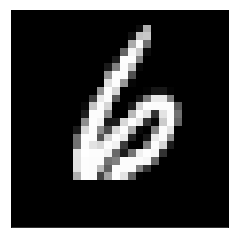

In [0]:
plt.imshow(training_data[0][10].reshape(28,-1), 'gray')
plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
training_data[1][10]

6

In [0]:
net.predict(training_data[0][10])

array([6], dtype=uint8)